# Q1

In [2]:
import pandas as pd 
import numpy as np
df = pd.read_excel("./data/proshares_analysis_data.xlsx", sheet_name="hedge_fund_series")
df.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
df = df.set_index('Date')
annualization_factor = 12


def calc_metrics(data):
    returns_df = pd.DataFrame(index = data.columns) 
    mu = data.mean() * annualization_factor
    vol = data.std() * np.sqrt(annualization_factor)
    sr = mu / vol
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values 
    return returns_df
calc_metrics(df)
    

,Annnualized Return,Annnualized Vol,Annnualized SR
HFRIFWI Index,0.048295,0.059476,0.812004
MLEIFCTR Index,0.036286,0.056136,0.646398
MLEIFCTX Index,0.034605,0.055980,0.618172
HDG US Equity,0.024812,0.058408,0.424805
QAI US Equity,0.025653,0.050009,0.512971


# Q2

In [4]:
# tail risks

def skewness(data): 
    mu = data.mean()
    numerator = ((data - mu)**(3)).mean()
    denominator = (data.std())**(3) 
    return numerator/denominator 

def kurtosis(data): 
    mu = data.mean()
    numerator = ((data - mu)**(4)).mean()
    denominator = (data.std())**(4) 
    return numerator/denominator 

def value_at_risk(data, quantile): 
    quantile_returns = data.quantile(quantile)
    return quantile_returns 

def cvar(data, quantile): 
    quantile_cut_off = data.quantile(quantile) 
    return data.loc[data.values < quantile_cut_off].mean()

def max_dd(data):
    #From Prof 2023 code
    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    max_dd = drawdowns.min()
    min_date = drawdowns.idxmin()
    peak_date = previous_peaks.idxmax()

    recovery_date = []
    prev_max = previous_peaks[: drawdowns.idxmin()].max()
    recovery_wealth = pd.DataFrame([wealth_index[drawdowns.idxmin() :]]).T
    recovery_date.append(
            recovery_wealth[recovery_wealth >= prev_max].index.min()
        )
    recovery = ["-" if pd.isnull(i) else i for i in recovery_date]

    return max_dd, min_date, peak_date, recovery
    

indices = df.columns 
results_df = pd.DataFrame(index = indices)
for index in indices:
    results_df.loc[index, 'Skewness'] = skewness(df[index])
    results_df.loc[index, 'Kurtosis'] = kurtosis(df[index])
    results_df.loc[index, 'VaR'] = value_at_risk(df[index], 0.05)
    results_df.loc[index, 'CVaR'] = cvar(df[index], 0.05)
    results_df.loc[index, 'Max DD'] = max_dd(df[index])[0]
    results_df.loc[index, 'Bottom Date'] = max_dd(df[index])[1]
    results_df.loc[index, 'Peak Date'] = max_dd(df[index])[2]
    results_df.loc[index, 'Recovery'] = max_dd(df[index])[3]
    
results_df
    

,Skewness,Kurtosis,VaR,CVaR,Max DD,Bottom Date,Peak Date,Recovery
HFRIFWI Index,-0.945104,8.436754,-0.024293,-0.037478,-0.115473,2020-03-31,2024-09-30,2020-03-31
MLEIFCTR Index,-0.260376,4.485347,-0.028189,-0.035857,-0.124302,2022-09-30,2024-09-30,2022-09-30
MLEIFCTX Index,-0.246528,4.451187,-0.028095,-0.035816,-0.124388,2022-09-30,2024-09-30,2022-09-30
HDG US Equity,-0.249395,4.607452,-0.030932,-0.037575,-0.140720,2022-09-30,2024-09-30,2022-09-30
QAI US Equity,-0.426555,4.460820,-0.017895,-0.032695,-0.137716,2022-09-30,2024-09-30,2022-09-30


# Q3

In [6]:
# regressions 
import statsmodels.api as sm 
spy = pd.read_excel("./data/proshares_analysis_data.xlsx", sheet_name="merrill_factors")
spy.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
combined_df = pd.merge(df, spy['SPY US Equity'], on = df.index)
combined_df.rename(columns = {'key_0':'Date'}, inplace=True)
combined_df = combined_df.set_index('Date')


def eval_performance(data, asset):
    y = data[asset]
    x = sm.add_constant(data['SPY US Equity'])
    model = sm.OLS(y, x).fit()
    beta = model.params['SPY US Equity']
    alpha = model.params['const']
    residuals = model.resid 
    std_error = np.std(residuals, ddof=1)

    treynor_ratio = y.mean()/beta 
    information_ratio = alpha/std_error
    
    return beta, treynor_ratio, information_ratio, alpha



assets = df.columns
results_df = pd.DataFrame(index = list(assets), columns = ['Market Beta', 'Treynor Ratio', 'Information Ratio'])
for asset in assets: 
    outcomes = eval_performance(combined_df, asset)
    results_df.loc[asset, 'Alpha'] = outcomes[3] * annualization_factor
    results_df.loc[asset, 'Market Beta'] = outcomes[0]
    results_df.loc[asset, 'Treynor Ratio'] = outcomes[1] * np.sqrt(annualization_factor)
    results_df.loc[asset, 'Information Ratio'] = outcomes[2] * np.sqrt(annualization_factor)
    
results_df
    


,Market Beta,Treynor Ratio,Information Ratio,Alpha
HFRIFWI Index,0.346131,0.040278,-0.035836,-0.001145
MLEIFCTR Index,0.343383,0.030505,-0.491479,-0.012761
MLEIFCTX Index,0.342171,0.029195,-0.549547,-0.014269
HDG US Equity,0.352053,0.020345,-0.896268,-0.025474
QAI US Equity,0.298376,0.024819,-0.675558,-0.016965


# Q4

The alphas are negative which suggest that these indices did not provide any outperformance and they all underperformed SPY. 
Nonetheless, as their betas are positive, they have some positive influence on the SPY. However, when we include the standard errors and obtain the information ratios, they indicate a strong underperformance. Information ratio refers to the tradeoff between obtaining an extra mean return from alpha at the cost of a taking on the tracking error from the portfolio. In this case, since the IR is negative, there is a strong underperformance of the hedge funds. 


QAI performs better since it has a lower beta (from the risk) and higher Treynor ratio = higher expected return per unit of market risk taken and a higher information ratio relative to the benchmark of the SPY. 

No. They do not capture the most notable proporties of HFRI. 

# Q5

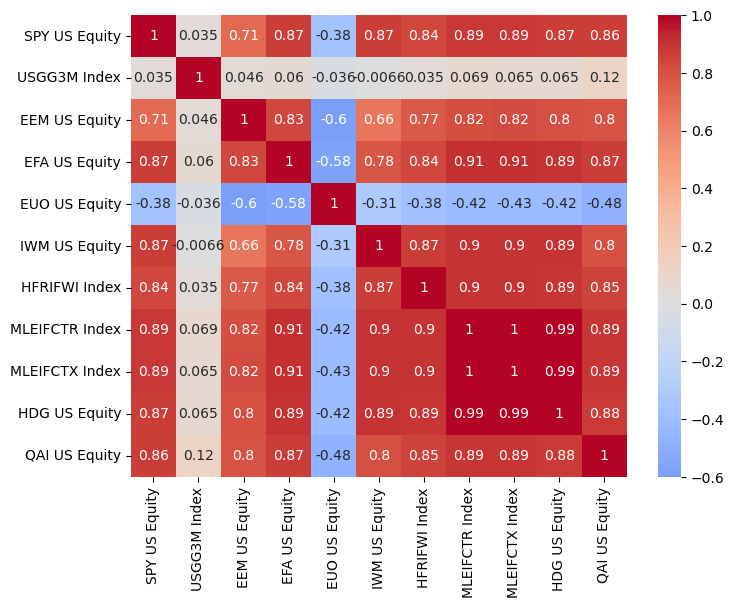

In [10]:
# corr mtx 
import seaborn as sns
import matplotlib.pyplot as plt
full_df = pd.concat([spy.set_index('Date'), df], axis = 1)
corr_mtx = full_df.corr() 
plt.figure(figsize=(8,6))
sns.heatmap(corr_mtx, annot=True, cmap='coolwarm', center = 0 )
plt.show()


In [11]:
corr_pairs = corr_mtx.unstack() 
corr_pairs = corr_pairs[corr_pairs != 1 ]
sorted_corr = corr_pairs.sort_values() 
sorted_corr.head(1), sorted_corr.tail(1)

(EEM US Equity  EUO US Equity   -0.601403
 dtype: float64,
 MLEIFCTR Index  MLEIFCTX Index    0.999909
 dtype: float64)

# Q6

In [13]:
merill_factors = pd.read_excel("./data/proshares_analysis_data.xlsx", sheet_name="merrill_factors")
merill_factors.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)
merill_factors.set_index('Date', inplace =True)
factors = list(merill_factors.columns)

combined_df = pd.merge(merill_factors, df['HFRIFWI Index'], on = merill_factors.index)
combined_df.rename(columns = {'key_0':'Date'}, inplace=True)
combined_df.set_index('Date', inplace=True)
3

get_params(combined_df)


/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_3832/109538815.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_model_alpha = model_alpha.params[0]


,Without Intercept,With Intercept
Alpha,0.000000,0.001235
R-Squared,0.845162,0.839676
SPY US Equity,0.050667,0.036483
USGG3M Index,0.499336,0.146336
EEM US Equity,0.080866,0.081611
EFA US Equity,0.079146,0.084638
EUO US Equity,0.031373,0.028806
IWM US Equity,0.142651,0.145111
Tracking Error,0.023908,0.023815


betas are all < 1 which suggests no outperformance. 
However, their p values are > 0.05 which suggest a lack of statistical relationship given the presence of multicollinearity amongst the features. No extreme long/short positions

# Q7

In [16]:
combined_df = combined_df.reset_index()
oos_data = merill_factors.copy()
is_data = combined_df.loc[:60].set_index('Date')

columns = list(merill_factors.columns) 

In [17]:
# regression estimation 
def regression(data: pd.DataFrame):
    y = data['HFRIFWI Index']
    x = sm.add_constant(data[columns])
    model = sm.OLS(y,x).fit() 
    return model

# in sample testing 
model = regression(is_data)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     54.76
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           3.34e-21
Time:                        18:05:42   Log-Likelihood:                 233.44
No. Observations:                  61   AIC:                            -452.9
Df Residuals:                      54   BIC:                            -438.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.001     -0.404      0.687      -0.003       0.002
SPY US Equity     0.0898      0.057      1.563      0.124      -0.025       0.205
USGG3M Index      9.7107     10.044      0.967      0.338     -10.426      29.847
EEM US Equity     0.0495      0.026      1.921      0.060      -0.002       0.101
EFA US Equity     0.1204      0.042      2.836      0.006       0.035       0.205
EUO US Equity     0.0232      0.018      1.315      0.194      -0.012       0.058
IWM US Equity     0.0732      0.034      2.185      0.033       0.006       0.140
==============================================================================
Omnibus:                        2.692   Durbin-Watson:                   1.770
Prob(Omnibus):                  0.260   Jarque-Bera (JB):                1.957
Skew:                          -0.419   Prob(JB):                        0.376
Kurtosis:                       3.261   Cond. No.                     1.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
start = 60 
summary = pd.DataFrame()
data = combined_df.copy()
for i in range(start, len(data), 1): 
    is_data = data.loc[i - 60:i, :]
    y = is_data['HFRIFWI Index']
    x = sm.add_constant(is_data[columns]) 
    model = sm.OLS(y, x).fit() 

    oos_x = data.loc[i, columns]
    oos_y = data.loc[i, 'HFRIFWI Index']
    date = data.loc[i, 'Date']
    
    y_pred = model.params[0] + (model.params[1:] @ oos_x)
    summary.loc[date, 'actual'] = oos_y
    summary.loc[date, 'replicated'] = y_pred



    

/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_3832/2861275874.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + (model.params[1:] @ oos_x)
/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_3832/2861275874.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.params[0] + (model.params[1:] @ oos_x)
/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_3832/2861275874.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

In [19]:
oos_rsquared = (
    1 - (summary["actual"] - summary["replicated"]).var() / summary["actual"].var()
)
print(f"OOS-R-Squared: {oos_rsquared:.2%}")


OOS-R-Squared: 87.66%


Text(0.5, 1.0, 'Actual vs Replicated values')

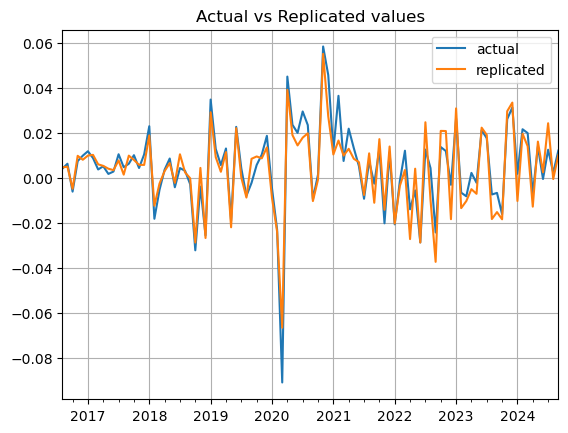

In [20]:
summary.plot()
plt.grid(True)

plt.title('Actual vs Replicated values')

# Q8

In [22]:
# full sample replication


def full_sample_replication(data, y_col='HFRIFWI Index', x_col=factors):
    columns = ['Alpha', 'R-Squared'] + x_col 
    params_df = pd.DataFrame(index=columns)
    
    y = data[y_col]
    x = data[x_col]
    model = sm.OLS(y, x).fit()
    r_squared = model.rsquared
    betas = model.params
    parameters = [0] + [r_squared] + list(betas)
    params_df['Without Intercept'] = parameters

    fitted_mean = (betas @ x.mean()) * 12
    
    
    x_alpha = sm.add_constant(x)
    model_alpha = sm.OLS(y, x_alpha).fit()
    r_squared_model_alpha = model_alpha.rsquared
    betas_model_alpha = model_alpha.params[1:]
    alpha_model_alpha = model_alpha.params[0]
    parameters = [alpha_model_alpha] + [r_squared_model_alpha] + list(betas_model_alpha) 
    params_df['With Intercept'] = parameters


    fitted_mean_alpha = (alpha_model_alpha + betas_model_alpha @ x.mean()) * 12
                   

    return params_df, fitted_mean, fitted_mean_alpha, y.mean() * 12

params_df, fitted_mean, fitted_mean_alpha, actual_mean = full_sample_replication(combined_df)
params_df

/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_3832/3700295908.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_model_alpha = model_alpha.params[0]


,Without Intercept,With Intercept
Alpha,0.000000,0.001235
R-Squared,0.845162,0.839676
SPY US Equity,0.050667,0.036483
USGG3M Index,0.499336,0.146336
EEM US Equity,0.080866,0.081611
EFA US Equity,0.079146,0.084638
EUO US Equity,0.031373,0.028806
IWM US Equity,0.142651,0.145111


In [23]:
fitted_mean, fitted_mean_alpha, actual_mean

(0.03954253530795934, 0.04829492300814171, 0.04829492300813211)

Yes, fitted with an intercept to capture alpha returns. 